
# Visualizing cross-validation behavior in scikit-learn

Choosing the right cross-validation object is a crucial part of fitting a
model properly. There are many ways to split data into training and test
sets in order to avoid model overfitting, to standardize the number of
groups in test sets, etc.

This example visualizes the behavior of several common scikit-learn objects
for comparison.


In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Patch

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

rng = np.random.RandomState(1338)
cmap_data = matplotlib.colormaps['Paired']
cmap_cv = matplotlib.colormaps['Paired']
n_splits = 4

## Visualize our data

First, we must understand the structure of our data. It has 100 randomly
generated input datapoints, 3 classes split unevenly across datapoints,
and 10 "groups" split evenly across datapoints.

As we'll see, some cross-validation objects do specific things with
labeled data, others behave differently with grouped data, and others
do not use this information.

To begin, we'll visualize our data.



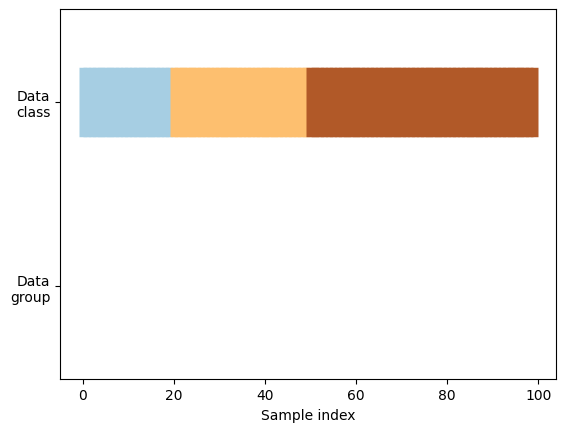

In [2]:
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.2, 0.3, 0.5]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

def visualize_groups(classes, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(y)),
        [3.5] * len(y),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, "no groups")

In [55]:
# Definir constantes
MOD = 10**9 + 7

def num_ways_to_paint_grid(n):
    if n == 1:
        return 12  # Base case
    
    # Inicialização para o caso n = 1
    same = 6  # Padrões onde duas cores são iguais na linha
    diff = 6  # Padrões onde todas as cores são diferentes na linha
    
    # Iterar para encontrar os valores para n > 1
    for _ in range(2, n + 1):
        new_same = (3 * same + 2 * diff) % MOD
        new_diff = (2 * same + 2 * diff) % MOD
        same, diff = new_same, new_diff
    
    return (same + diff) % MOD

# Exemplo de teste para n = 1 (dado no problema)
num_ways_to_paint_grid(5000)

30228214

## Define a function to visualize cross-validation behavior

We'll define a function that lets us visualize the behavior of each
cross-validation object. We'll perform 4 splits of the data. On each
split, we'll visualize the indices chosen for the training set
(in blue) and the test set (in red).



In [3]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

Let's see how it looks for the :class:`~sklearn.model_selection.KFold`
cross-validation object:



<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

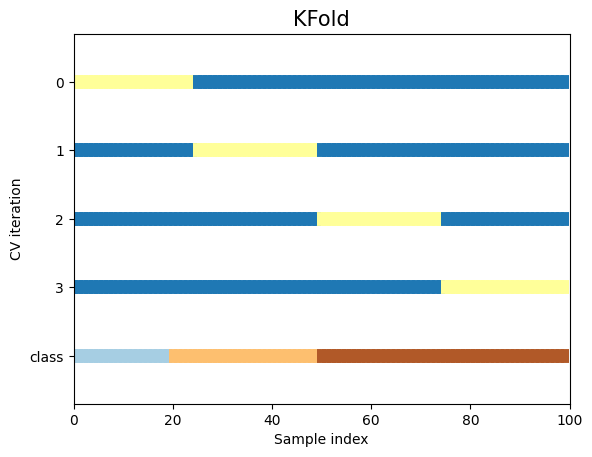

In [6]:
fig, ax = plt.subplots()
groups = 0
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

As you can see, by default the KFold cross-validation iterator does not
take either datapoint class or group into consideration. We can change this
by using either:

- ``StratifiedKFold`` to preserve the percentage of samples for each class.
- ``GroupKFold`` to ensure that the same group will not appear in two
  different folds.
- ``StratifiedGroupKFold`` to keep the constraint of ``GroupKFold`` while
  attempting to return stratified folds.



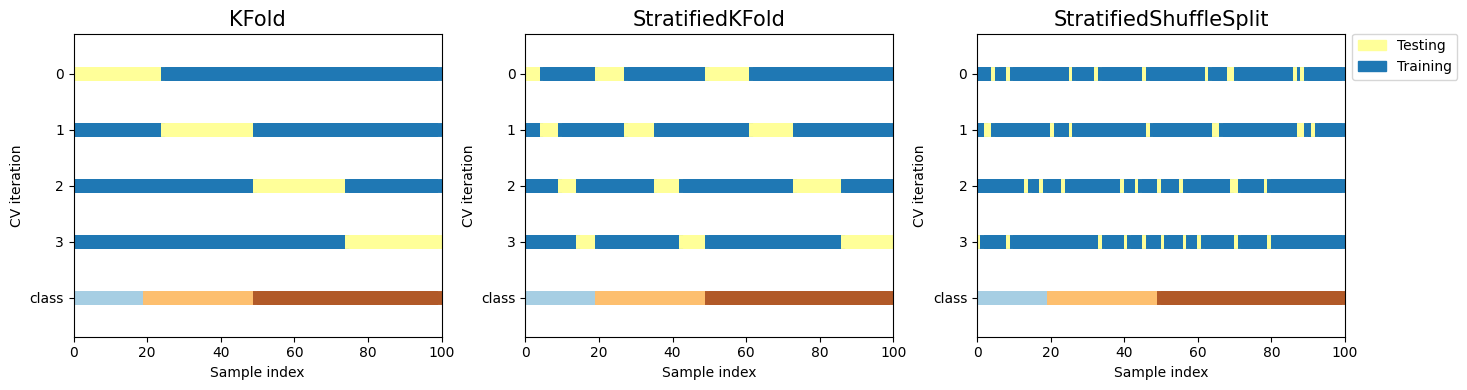

In [23]:
cvs = [KFold, StratifiedKFold, StratifiedShuffleSplit]
fig, axes = plt.subplots(1,3,figsize=(15, 4))
for cv, ax in zip(cvs, axes):
    
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    plt.tight_layout()
    fig.subplots_adjust(right=0.9)
ax.legend(
    [Patch(color=cmap_data.colors[-2]), Patch(color=cmap_data.colors[1])],
    ["Testing", "Training"],
    loc=(1.02, 0.85),
)
    # Make the legend fit
    
fig.savefig('./Data/results/charts/kfolding_exmaple.pdf', dpi=300, format = 'pdf', pad_inches=0.0)

In [114]:
import pandas as pd
import seaborn as sns
import numpy as np

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object using Seaborn."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None

    # Criar DataFrames para splits e classes
    splits_data = []
    for split_idx, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        indices = np.zeros(len(X), dtype=int)
        indices[tt] = 1
        for sample_idx, val in enumerate(indices):
            splits_data.append({
                'Sample Index': sample_idx,
                'CV Iteration': split_idx + 0.5,
                'Value': val
            })
    
    # DataFrame para splits
    splits_df = pd.DataFrame(splits_data)
    
    # DataFrame para classes
    class_df = pd.DataFrame({
        'Sample Index': np.arange(len(X)),
        'CV Iteration': n_splits + 0.5,
        'Value': y
    })

    # Plotar splits usando Seaborn
    sns.scatterplot(
        x='Sample Index',
        y='CV Iteration',
        hue='Value',
        data=splits_df,
        palette=cmap_cv,
        marker='_',
        linewidth=lw,
        ax=ax,
        legend=False
    )
    
    # Plotar classes em uma linha separada
    sns.scatterplot(
        x='Sample Index',
        y='CV Iteration',
        hue='Value',
        data=class_df,
        palette=cmap_data,
        marker='_',
        linewidth=lw,
        ax=ax,
        legend=False
    )

    # Configurações de formatação
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel='Sample index',
        ylabel='CV iteration',
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X)]
    )
    ax.set_title(f"{type(cv).__name__}", fontsize=15)
    
    return ax

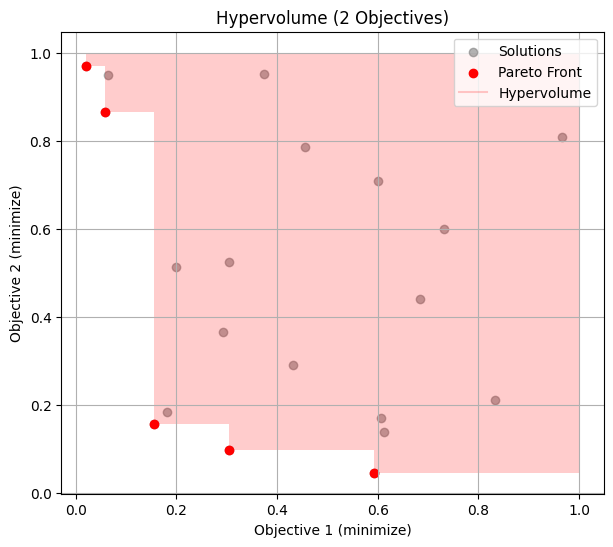

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def is_dominated(p, others):
    """
    Checks if a point p (px, py) is dominated by any point in 'others'.
    For minimization: p is dominated if there exists q in others such that
    qx <= px and qy <= py, with at least one strict inequality.
    """
    for q in others:
        if (q[0] <= p[0] and q[1] <= p[1]) and (q[0] < p[0] or q[1] < p[1]):
            return True
    return False

def get_pareto_front(points):
    """
    Returns the list of non-dominated points (Pareto front) from a
    set of 2D points, considering minimization for both objectives.
    """
    pareto = []
    for p in points:
        if not is_dominated(p, points):
            pareto.append(p)
    return np.array(pareto)

# Generate random points
np.random.seed(42)
N = 20
points = 1 * np.random.rand(N, 2)

# Obtain Pareto front points and sort them by the first objective (x)
pareto_points = get_pareto_front(points)
pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]

# Define the reference point (using the maximum values of points plus an offset)
ref_point = [1,1]

# Plot
plt.figure(figsize=(7, 6))
plt.scatter(points[:, 0], points[:, 1], color='gray', alpha=0.6, label='Solutions')
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='red', label='Pareto Front')

# Draw hypervolume rectangles for the Pareto front
for i in range(len(pareto_points)):
    x = pareto_points[i][0]
    y = pareto_points[i][1]
    # Determine the right boundary for the rectangle
    if i < len(pareto_points) - 1:
        next_x = pareto_points[i + 1][0]
    else:
        next_x = ref_point[0]
    
    # Define the vertices of the rectangle
    rectangle = np.array([
        [x, y],
        [next_x, y],
        [next_x, ref_point[1]],
        [x, ref_point[1]]
    ])
    
    # Fill the rectangle without drawing contour lines
    plt.fill(rectangle[:, 0], rectangle[:, 1],
             color='red', alpha=0.2, edgecolor="none")

# Legend adjustment: add a dummy plot for the hypervolume region
plt.plot([], [], color='red', alpha=0.2, label='Hypervolume')

# Axis labels and title in English
plt.title('Hypervolume (2 Objectives)')
plt.xlabel('Objective 1 (minimize)')
plt.ylabel('Objective 2 (minimize)')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('./Data/results/charts/hypervolume_example.pdf', dpi=300, format = 'pdf', pad_inches=0.0)